### コンプレッサの無次元数マップをカーブフィッティングするコード

#### Step 0 : 必要なパッケージをインポート

フィッティングにはscipyを使用する

In [6]:
import numpy as np                                              # 数値計算用                              
from scipy.optimize import leastsq, curve_fit, least_squares    # カーブフィッティング用
import matplotlib.pyplot as plt                                 # グラフ描画用
import pandas as pd                                             # データフレーム操作用
from tkinter import Tk, filedialog

#### Step1 & 2 : フィッティングしたい式の定義 & 誤差関数の定義

フィッティングする式は以下の通り。
$$
\phi = \phi_{\max}\left[1-\exp \left(\beta\left(\frac{\mu_y}{\mu_{y,\max}}-1\right)\right)\right]
$$

$$
\begin{aligned}
    \phi_{\max} & =a_4 M^4+a_3 M^3+a_2 M^2+a_1 M+a_0 \\
    \mu_{y,\max} & =c_5 M^5+c_4 M^4+c_3 M^3+c_2 M^2+c_1 M+c_0\\
    \beta & =b_2 M^2+b_1 M+b_0
\end{aligned}
$$

ただし，$M$はマッハ数とする。

In [7]:
# Step1 : フィッティングしたい式を定義 ------------------------------------------------------------

# phiとmuyの関係式を定義
def fitingCurve_phi(prm,x) :
    phi_max, MUy_max, beta = prm[0], prm[1], prm[2]
    MUy = x
    return phi_max * (1 -  np.exp((MUy/MUy_max -1)*beta))

# 多項式の定義式
def fitingCurve_poly(prm,x) :
    coeff = prm
    y = 0
    # y = coeff[0] * x**4 + coeff[1] * x**3 + coeff[2] * x**2 + coeff[3]* x + coeff[4]
    for i in range(len(coeff)) :
        y += coeff[i] * x ** (len(coeff)-(i+1))
    return y


# Step2 : フィッテング式の値とデータサンプルとの誤差を計算する式を定義する　--------------------------
def objFunc_phi(prm, x, y):
    residual = y-fitingCurve_phi(prm,x)
    return residual

def objFunc_poly(prm, x, y):
    residual = y-fitingCurve_poly(prm,x)
    return residual


#### Step3 : データの読み出し
各マッハ数 $M$ ごとに $(x,y) = (\mu_y,\phi)$ の組を読み出す

In [8]:
# Step3 : データサンプルを用意　------------------------------------------------------------------
# ダイアログでフォルダを選択
# Tkinter のルートウィンドウを作成
root = Tk()
root.withdraw()                     # 余分なウィンドウを表示しないようにする
root.attributes("-topmost", True)   # フォルダ選択ダイアログを前面に表示する
# フォルダ選択ダイアログを開く
folder_path = filedialog.askdirectory(title="フォルダを選択してください",initialdir='./')
# 結果を表示
print("選択されたフォルダ:", folder_path)
# ファイル名を取得する
x_all = np.loadtxt(folder_path + "/Input/Muy_MU2vsMUy.csv",delimiter=',')
y_all = np.loadtxt(folder_path + "/Input/phi_MU2vsphi.csv",delimiter=',')

選択されたフォルダ: C:/MyStudy/OptimizationStudy/Cmapfitting/Test


#### Step4 : $\phi$ と $\mu_y$ の関係のフィッティング

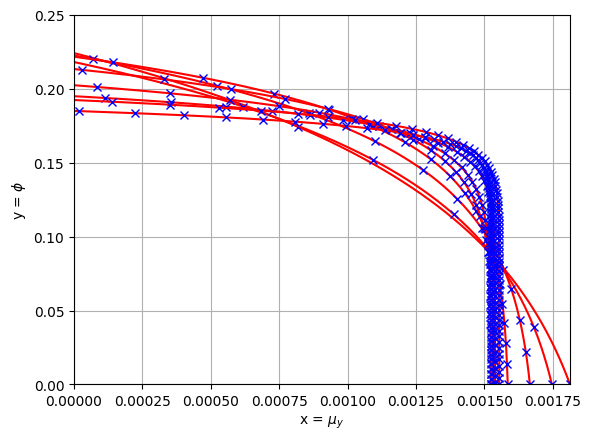

In [9]:
# Step4 : phiとmuyの関係をフィッティング ---------------------------------------------------------
# フィッティングパラメータの初期化
phi_max = np.zeros(x_all.shape[0])
muy_max = np.zeros(x_all.shape[0])
beta = np.zeros(x_all.shape[0])
for i in range(x_all.shape[0]) :
    x = x_all[i]
    y = y_all[i]
    y = y[y>-0.05]
    x = x[0:len(y)]
    xq  = np.linspace(np.amin(x),np.amax(x),1000) # プロット用に細かい定義域の変数を用意しておく

    # フィッテングするパラメータ (a,b) の探索前の初期値を設定
    x0=np.array([0.1, 0.1, 0.1])

    # 非線形最小二乗計算
    # least_swuaresの解釈 x0がa,b,cにあたる独立変数, f_sacaleは許容誤差（デフォルト値は1e-8），argsがinputデータ
    # 詳細URL:https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
    # 損失関数はlinear,soft_l1,cauchyから選ぶ
    # result = least_squares(func, x0, loss='linear', f_scale=0.1, args=(x, y))
    result = least_squares(objFunc_phi, x0, loss='linear', args=(x, y))
    phi_max[i], muy_max[i], beta[i] = result.x[0], result.x[1], result.x[2]
    yq = fitingCurve_phi(result.x, xq)

    # グラフ作成　------------------------------------------------------------------------
    plt.plot(yq,xq, color='red', label='y_linear')
    plt.plot(y, x, 'bx', label='y-original')
    plt.xlabel(r'x = $\mu_y$')
    plt.ylabel(r'y = $\phi$')

plt.xlim(0,np.amax(y_all))
plt.ylim(0,0.25)
plt.grid(True)

# グラフの保存
plt.savefig(folder_path + '/Output/MUy_vs_phi.png')

# グラフの表示
plt.show()

# fittingしたパラメータを保存
np.savetxt(folder_path + '/Output/phi_max.csv', phi_max)
np.savetxt(folder_path + '/Output/muy_max.csv', muy_max)
np.savetxt(folder_path + '/Output/beta.csv', beta)


#### Step5 : マッハ数 $M$ との関係をフィッティング
$\phi_{\max}$, $\mu_{y\max}$, $\beta$ を $M$ でフィッティングする。 <br>
※ このサンプルでは $M$ のデータテーブルは "MU2.csv" に格納。


    coeff_a   coeff_b   coeff_c
0 -0.000037  1.766468 -0.009788
1  0.000270 -1.348375  0.105810
2 -0.000536  2.444193 -0.429370
3 -0.000046       NaN  0.801210
4  0.002212       NaN -0.683440
5       NaN       NaN  0.433310


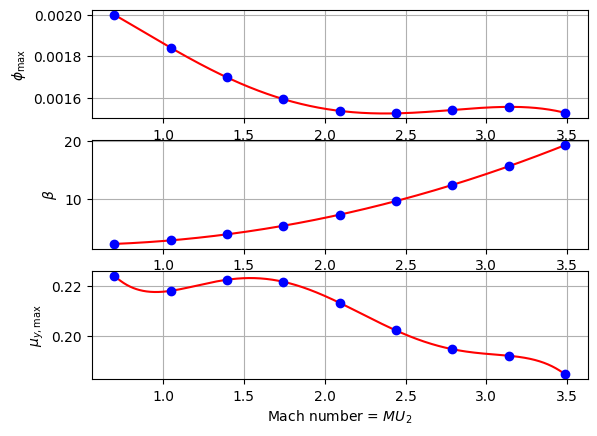

In [10]:
# Step5 : MU2との関係をフィッティング ---------------------------------------------------------
MU2_sample = np.loadtxt(folder_path + '/Input/MU2.csv',delimiter=',')
# フィッティングパラメータの初期化
coeff_a = np.ones(5) * 0.1
coeff_b = np.ones(3) * 0.1
coeff_c = np.ones(6) * 0.1
MU2q  = np.linspace(np.amin(MU2_sample),np.amax(MU2_sample),1000) # プロット用に細かい定義域の変数を用意しておく

# Figure用意

# 非線形最小二乗計算
# coeff a --- phi_max
result = least_squares(objFunc_poly, coeff_a, loss='soft_l1', args=(MU2_sample, phi_max))
coeff_a = result.x
phi_maxq = fitingCurve_poly(result.x, MU2q)
# coeff b --- beta
result = least_squares(objFunc_poly, coeff_b, loss='linear', args=(MU2_sample, beta))
coeff_b = result.x
betaq = fitingCurve_poly(result.x, MU2q)
# coeff_c --- muy_max
result = least_squares(objFunc_poly, coeff_c, loss='linear', args=(MU2_sample, muy_max))
coeff_c = result.x
muy_maxq = fitingCurve_poly(result.x, MU2q)

# グラフ作成
fig = plt.figure()
# coeff a
plt.subplot(3,1,1)
plt.plot(MU2q, phi_maxq, color='red', label='y_linear')
plt.plot(MU2_sample, phi_max, 'bo', label='y-original')
plt.ylabel(r'$\phi_{\max}$')
plt.grid(True)
# coeff b
plt.subplot(3,1,2)
plt.plot(MU2q, betaq, color='red', label='y_linear')
plt.plot(MU2_sample, beta, 'bo', label='y-original')
plt.ylabel(r'$\beta$')
plt.grid(True)
# coeff c
plt.subplot(3,1,3)
plt.plot(MU2q, muy_maxq, color='red', label='y_linear')
plt.plot(MU2_sample, muy_max, 'bo', label='y-original')
plt.ylabel(r'$\mu_{y,\max}$')
plt.xlabel(r'Mach number = $MU_2$')
plt.grid(True)

# 係数をテーブルで出力するために長さを揃える
max_length = max(len(coeff_a), len(coeff_b), len(coeff_c))
coeff_a = np.pad(coeff_a, (0, max_length - len(coeff_a)), 'constant', constant_values=np.nan)
coeff_b = np.pad(coeff_b, (0, max_length - len(coeff_b)), 'constant', constant_values=np.nan)
coeff_c = np.pad(coeff_c, (0, max_length - len(coeff_c)), 'constant', constant_values=np.nan)

coeff = {
    'coeff_a': coeff_a,
    'coeff_b': coeff_b,
    'coeff_c': coeff_c
}
df_coefficients = pd.DataFrame(coeff)

# グラフの保存
plt.savefig(folder_path + '/Output/MU2_vs_coeff.png')

# 表示
print(df_coefficients)
plt.show()

# テーブル保存
df_coefficients.to_csv(folder_path + '/Output/coeff.csv',index=False)
